In [1]:
import sys
sys.path.append('python/')

import time
startTime = time.time()

import numpy as np
import matplotlib.pyplot as plt 
import load_galaxies as lg
import matplotlib.image as mpimg
import lmfit as lm

_Python help: Running the notebook the first time, make sure to run all cells to be able to make changes in the notebook. Hit Shift+Enter to run the cell or click on the top menu: Kernel > Restart & Run All > Restart and Run All Cells to rerun the whole notebook. If you make any changes in a cell, rerun that cell._

# Fitting

In this notebook, you can select one of four galaxies, import the prepared curves of all components and find the scaling factors by fitting them to the measured data points. The dark matter component has two free parameters: one that changes the amplitude of the curve (rho0 - central mass density) and the other that changes the shape of the curve (rc - core radius). Let's import all the data and curves, and define some functions for the fitting. 

## Choose your galaxy

In [2]:
galaxy = lg.NGC5533                  # Choose between NGC5533, NGC891, NGC7814 and NGC5005 galaxies

## Import data and curves

In [3]:
# Measured data
measured_data = galaxy['measured_data']

# Separate the columns into arrays
m_radii = galaxy['m_radii']
m_velocities = galaxy['m_velocities']
m_r_errors = galaxy['m_r_errors']
m_v_errors = galaxy['m_v_errors']    # Errors in velocity

# Velocity equation for the central supermassive black hole
massbh = galaxy['massbh']            # Mass of the central black hole in (solar mass)
G = 4.300e-6                         # Gravitational constant (kpc/solar mass*(km/s)^2)
def blackhole_v(r,massbh):
    return np.sqrt((G*massbh)/r)

# Import curves of each component
# Bulge
bulge_v = galaxy['bulge']['spline']
# Disk
disk_v = galaxy['disk']['spline']
# Gas
gas_v = galaxy['gas']['spline']

## Calculate dark matter halo component

In [4]:
# Set parameters
rho0 = galaxy['rho0']   # central mass density (in solar mass/kpc^3)
rc = galaxy['rc']       # core radius (in kpc)

# Equation for dark matter halo velocity
def halo_v(r,rho0,rc):
    v = np.sqrt(4*np.pi*G*rho0*rc**2*(1 - rc/r * np.arctan(r/rc)))
    return v

## Define some values and functions

In [5]:
# Express weight
weighdata = 1/m_v_errors

"""# Define function for total velocity with prefactors
def total_v_pref(r,massbh,bpref,dpref,gpref,hpref):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bpref*bulge_v(r))**2 
                   + (dpref*disk_v(r))**2 
                   + (gpref*gas_v(r))**2
                   + (hpref*halo_v(r))**2)"""

# Define function for total velocity with prefactors (scaling parameters)
def total_v_pref(r,massbh,bpref,dpref,gpref,rho0,rc):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bpref*bulge_v(r))**2 
                   + (dpref*disk_v(r))**2 
                   + (gpref*gas_v(r))**2
                   + (halo_v(r,rho0,rc)**2))

# Define function for total velocity with prefactors (scaling parameters), with no dark matter
def total_v_pref_noDM(r,massbh,bpref,dpref,gpref):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bpref*bulge_v(r))**2 
                   + (dpref*disk_v(r))**2 
                   + (gpref*gas_v(r))**2)

## Fitting parameters

1. Parameters can be varied during the fit. __Turn these off and on by changing 'vary=True' to 'vary=False' or 'vary=False' to 'vary=True' to see how your results of the fit change.__<br><br>

2. __Now, use the total velocity equation without dark matter (total_v_pref_noDM equation) and find the fitting parameters. You can comment out (put a # in front of) the lines: "f_params.add('rc'..." and "f_params.add('rho0'..." so it won't confuse you.__ <br>
_Python help: to use a different equation for the fitting, change the line: f_\__mod = lm.Model(equation)._

In [6]:
# Setup 
f_mod = lm.Model(total_v_pref)
#f_mod = lm.Model(total_v_pref_noDM)
f_params = f_mod.make_params()

# Halo
#f_params.add('hpref',    vary=True,    value=1,   min=0.1)       # halo prefactor
f_params.add('rc',      vary=True,     value=rc,   min=0.1)       # core radius (kpc)
f_params.add('rho0',    vary=True,     value=rho0, min=0)         # central halo density (solar mass/kpc^3)

# Black Hole
f_params.add('massbh',  vary=True,    value=massbh, min=1.0e8)   # mass of central black hole

# Bulge
f_params.add('bpref',   vary=True,    value=1,   min=0,max=100)  # bulge prefactor

# Disk
f_params.add('dpref',   vary=True,    value=1,   min=0,max=100)  # disk prefactor

# Gas
f_params.add('gpref',   vary=True,    value=1,   min=.8,max=1.2) # gas prefactor

## Do the fitting

Let Python calculate the fitting parameters and display the fit statistics. Examine the results for the values of each variable. 

In [7]:
f_fit = f_mod.fit(m_velocities,f_params,r=m_radii,weights=weighdata)

# Show fit statistics
f_fit

### Chi-square $\chi^2$:

The chi-squared value is an indication of the goodness of your fit or how well the observed and expected data agree. A zero chi-squared value would mean a perfect fit (data points connected with a line) which would mean a nonphysical system and is highly unlikely. The expected value of chi-squared is the number of degrees of freedom or "the number of observed points minus the number of parameters computed from the data and used in the calculation" (Taylor, 1997).


### Reduced chi-square
The reduced chi-squared value is the chi-squared value divided by the degree of freedom. In general, we would want this value to be close to 1 to be a good fit. 

## Define parameters for plotting

In [8]:
# Define curve of the best fit
bestf = f_fit.best_fit

# Radius
r_lowerlim = np.min(m_radii)                       # limit the radius to the min value of the measured radius
r_upperlim = np.max(m_radii)                       # limit the radius to the max value of the measured radius
r = np.linspace(r_lowerlim,r_upperlim,100)         # starting from zero results in a divide by zero error

## Plot result

1. __Zoom into the graph by changing the limits of the x-axis to see how well the total curve lines up with the measured points.__

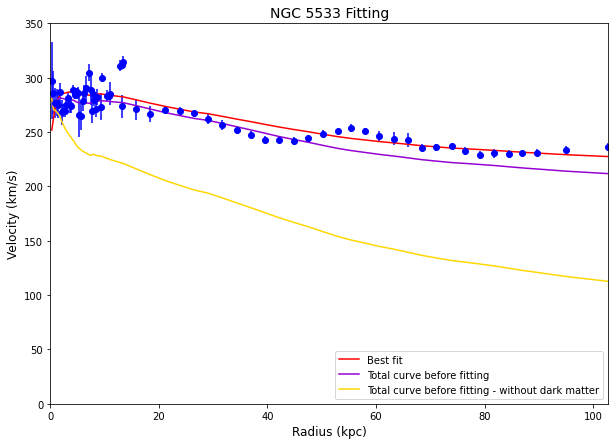

In [9]:
plt.figure(figsize=(10.0,7.0))                                     # size of the plot
plt.title('{} Fitting'.format(galaxy['galaxyname']), fontsize=14)  # giving the plot a title
plt.xlabel('Radius (kpc)', fontsize=12)                            # labeling the x-axis
plt.ylabel('Velocity (km/s)', fontsize=12)                         # labeling the y-axis
plt.xlim(0,r_upperlim)                                             # limits of the x-axis
plt.ylim(0,350)                                                    # limits of the y-axis

plt.errorbar(m_radii,m_velocities,yerr=m_v_errors,fmt='bo')        # plot measured data points
plt.plot(m_radii,bestf, color='r', label='Best fit')               # plot the best fit to the data points
plt.plot(m_radii,total_v_pref(m_radii,massbh=massbh,bpref=1,dpref=1,gpref=1,rho0=rho0,rc=rc), \
         color='darkviolet', label='Total curve before fitting')   
plt.plot(m_radii,total_v_pref_noDM(m_radii,massbh=massbh,bpref=1,dpref=1,gpref=1), \
         color='gold', label='Total curve before fitting - without dark matter')

plt.legend(loc="lower right")
plt.show()

## Bonus: Calculate the total mass of the dark matter

1. __Using the equation for the Mass as a function of radius, $M(r)$ from the Interactive_Rotation_Curve_Plotting notebook, calculate the total mass enclosed within the given radius. For the mass density, $\rho (r)$ function, use either the isothermal or the NFW density distribution.__ <br><br>

2. __Change the radius to see how much the total mass of the dark matter changes.__<br>
_Python help: Modify the radius by changing the line: radius = 25_

In [10]:
import scipy.integrate as si             # for integration

# Equation for isothermal density
def density_iso(r,rho0,rc):
    density = rho0 * (1 + (r/rc)**2)**(-1)
    return density

# Equation for NFW density
def density_nfw(r,rho0,rc):
    density = rho0 * ((r/rc) * ((1+r/rc)**2))**(-1)
    return density

# Equation for mass as a function of radius
def mass_function(r,rho0,rc):
    mass = 4 * np.pi * density_iso(r,rho0,rc) * r**2
    return mass

# Integrate to calculate total mass enclosed
totalmass = lambda r,rho0,rc: si.quad(mass_function, 0, r, args=(rho0,rc))[0]

# Radius at which we are calculating the total mass enclosed
radius = 25   # in kpc

# Total mass
print("Total mass of the dark matter between 0 and {} kpc is {:.3e} solar masses.".format(radius,totalmass(radius,rho0,rc)))

Total mass of the dark matter between 0 and 25 kpc is 1.747e+11 solar masses.


## Bonus: Difference between isothermal and NFW density profiles of the dark matter halo

Examine the difference between the two density profiles for the dark matter halo.

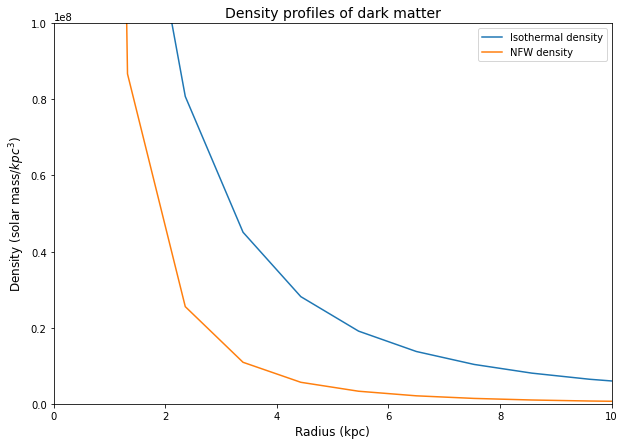

In [11]:
plt.figure(figsize=(10.0,7.0))                            # size of the plot
plt.plot(r,density_iso(r,rho0,rc), label='Isothermal density')
plt.plot(r,density_nfw(r,rho0,rc), label='NFW density')
plt.title('Density profiles of dark matter', fontsize=14) # giving the plot a title
plt.xlabel('Radius (kpc)', fontsize=12)                   # labeling the x-axis
plt.ylabel('Density (solar mass/$kpc^3$)', fontsize=12)                        # labeling the y-axis
plt.xlim(0,10)                                            # limits of x-axis
plt.ylim(0,1e8)                                           # limits of y-axis
plt.legend(loc="upper right")
plt.show()

In [12]:
# Time
executionTime = (time.time() - startTime)
ttt=executionTime/60
print(f'Execution time: {ttt:.2f} minutes')

Execution time: 0.04 minutes


# References <br>
>Casertano, Stefano. __"Rotation curve of the edge-on spiral galaxy NGC 5907: disc and halo masses."__ _Monthly Notices of the Royal Astronomical Society_ 203, no. 3 (1983): 735-747. https://doi.org/10.1093/mnras/203.3.735. <br><br>
>Fraternali, F., R. Sancisi, and P. Kamphuis. __“A Tale of Two Galaxies: Light and Mass in NGC 891 and NGC 7814.”__ Astronomy &amp; Astrophysics 531 (June 13, 2011). https://doi.org/10.1051/0004-6361/201116634.<br><br> 
>Jimenez, Raul, Licia Verde, and S. Peng Oh. __"Dark halo properties from rotation curves."__ _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259. https://doi.org/10.1046/j.1365-8711.2003.06165.x. <br><br>
>Kapteyn Institute. (n.d.). Groningen Image Processing System. __GIPSY, the GRONINGEN image processing system.__ https://www.astro.rug.nl/~gipsy/index.html. <br><br>
>Karukes, E. V., P. Salucci, and Gianfranco Gentile. __"The dark matter distribution in the spiral NGC 3198 out to 0.22 $R_{vir}$."__ _Astronomy & Astrophysics_ 578 (2015): A13. https://doi.org/10.1051/0004-6361/201425339. <br><br>
>Noordermeer, Edo. __"The rotation curves of flattened Sérsic bulges."__ _Monthly Notices of the Royal Astronomical Society_ 385, no. 3 (2007): 1359-1364. https://doi.org/10.1111/j.1365-2966.2008.12837.x. <br><br>
>Di&nbsp;Paolo, Chiara, Paolo Salucci, and Adnan Erkurt. __“The Universal Rotation Curve of Low Surface Brightness Galaxies – IV. The Interrelation Between Dark and Luminous Matter.”__ Monthly Notices of the Royal Astronomical Society 490, no. 4 (September 26, 2019): 5451–77. https://doi.org/10.1093/mnras/stz2700. <br><br>
>Richards, Emily E., L. van Zee, K. L. Barnes, S. Staudaher, D. A. Dale, T. T. Braun, D. C. Wavle, et al. __“Baryonic Distributions in the Dark Matter Halo of NGC 5005.”__ Monthly Notices of the Royal Astronomical Society 449, no. 4 (June 1, 2015): 3981–96. https://doi.org/10.1093/mnras/stv568. <br><br>
>Taylor, John Robert. __An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.__ 2nd ed. United States of America: University Science Books, 1997. 
***